# Learning to Control Incompressible Fluids with Differentiable Physics
This notebook will walk you through data generation, supervised network initialization and end-to-end training using our differentiable PDE solver, [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

The code below replicates the shape transitions (experiment 2 from the ICLR 2020 paper [Learning to Control PDEs with Differentiable Physics](https://ge.in.tum.de/publications/2020-iclr-holl/)). The original experiment was performed on an older version of the solver, the code for which can be found under `/legacy`. The experiment is described in detail in section D.2 of the [appendix](https://openreview.net/pdf?id=HyeSin4FPB).

If you havn't already, check out the notebook on controlling Burgers' Equation. It covers the basics in more detail.

In [ ]:
import sys; sys.path.append('../PhiFlow'); sys.path.append('../src')
from shape_utils import load_shapes, distribute_random_shape
from control.pde.incompressible_flow import IncompressibleFluidPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence
import matplotlib.pyplot as plt
from phi.flow import *

## Data Generation

In [2]:
domain = Domain([64, 64])  # 1D Grid resolution and physical size
step_count = 16  # how many solver steps to perform
dt = 1.0  # Time increment per solver step
example_count = 1000
batch_size = 100
data_path = 'shape-transitions'
pretrain_data_path = 'moving-squares'
shape_library = load_shapes('shapes')

The following cell creates the dataset we want to train our model on.
Each example consists of a start and target (end) frame which are generated by placing a random shape somewhere within the domain.

In [3]:
for scene in Scene.list(data_path): scene.remove()

for _ in range(example_count // batch_size):
    scene = Scene.create(data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    start = distribute_random_shape(domain.resolution, batch_size, shape_library)
    end__ = distribute_random_shape(domain.resolution, batch_size, shape_library)
    [scene.write_sim_frame([start], ['density'], frame=f) for f in range(step_count)]
    scene.write_sim_frame([end__], ['density'], frame=step_count)

shape-transitions\sim_000000
shape-transitions\sim_000100
shape-transitions\sim_000200
shape-transitions\sim_000300
shape-transitions\sim_000400
shape-transitions\sim_000500
shape-transitions\sim_000600
shape-transitions\sim_000700
shape-transitions\sim_000800
shape-transitions\sim_000900


Since this dataset does not contain any intermediate frames, it does not allow for supervised pretraining. This is because to pre-train a CFE, two consecutive frames are required and to pretrain an $OP_n$, three frames with distance $n/2$ are needed.

Instead, we create a second dataset which contains intermediate frames. This does not need to look like the actual dataset since it's only used for network initialization. Here, we linearly move a rectangle around the domain.

In [10]:
for scene in Scene.list(pretrain_data_path): scene.remove()

for scene_index in range(example_count // batch_size):
    scene = Scene.create(pretrain_data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    pos0 = np.random.randint(10, 56, (batch_size, 2))  # start position
    pose = np.random.randint(10, 56, (batch_size, 2))  # end position
    size = np.random.randint(6,  10,  (batch_size, 2))
    for frame in range(step_count+1):
        time = frame / float(step_count + 1)
        pos = np.round(pos0 * (1 - time) + pose * time).astype(np.int)
        density = AABox(lower=pos-size//2, upper=pos-size//2+size).value_at(domain.center_points())
        scene.write_sim_frame([density], ['density'], frame=frame)

moving-squares\sim_000000
moving-squares\sim_000100
moving-squares\sim_000200
moving-squares\sim_000300
moving-squares\sim_000400
moving-squares\sim_000500
moving-squares\sim_000600
moving-squares\sim_000700
moving-squares\sim_000800
moving-squares\sim_000900


# Supervised Initialization

In [3]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains the $OP_2$, $OP_4$, $OP_8$, $OP_{16}$ networks from scratch. You can skip it and load the checkpoints by running the cell after.

In [ ]:
supervised_checkpoints = {}

for n in [2, 4, 8, 16]:
    app = ControlTraining(n, IncompressibleFluidPDE(domain, dt),
                          datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                          obs_loss_frames=[n//2], trainable_networks=['OP%d' % n],
                          sequence_class=None).prepare()
    for i in range(1000):
        app.progress()  # Run Optimization for one batch
    supervised_checkpoints['OP%d' % n] = app.save_model()

In [ ]:
supervised_checkpoints

In [5]:
# supervised_checkpoints = {'OP%d' % n: '../networks/shapes/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}

# CFE Pretraining with Differentiable Physics

To pretrain the CFE, we set up a simulation with a single step of the differentiable solver.

The following cell trains the CFE network from scratch. You can skip it an load the checkpoint by running the cell after.

In [ ]:
app = ControlTraining(1, IncompressibleFluidPDE(domain, dt),
                      datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                      obs_loss_frames=[1], trainable_networks=['CFE']).prepare()
for i in range(1000):
    app.progress()  # Run Optimization for one batch
supervised_checkpoints['CFE'] = app.save_model()

In [1]:
# supervised_checkpoints['CFE'] = '../networks/shapes/CFE/CFE_2000'

# End-to-end Training with Differentiable Physics

Now, we jointly train $CFE$ and all $OP_n$ networks. The following cell builds the computational graph with `step_count` solver steps without initializing the network weights.

In [ ]:
staggered_app = ControlTraining(step_count, IncompressibleFluidPDE(domain, dt),
                                datapath=data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                                obs_loss_frames=[step_count], trainable_networks=['CFE', 'OP2', 'OP4', 'OP8', 'OP16'],
                                sequence_class=StaggeredSequence, learning_rate=5e-4).prepare()

The next cell initializes the networks using the supervised checkpoints and then trains all networks jointly. You can skip it and load the checkpoint by running the cell after.

In [ ]:
staggered_app.load_checkpoints(supervised_checkpoints)
for i in range(1000):
    staggered_app.progress()  # Run staggered Optimization for one batch
staggered_checkpoint = staggered_app.save_model()

In [ ]:
# staggered_checkpoint = {net: '../networks/shapes/staggered/all_53750' for net in ['CFE', 'OP2', 'OP4', 'OP8', 'OP16']}
# staggered_app.load_checkpoints(staggered_checkpoint)

Now that the network is trained, we can infer some trajectories from the test set.
This corresponds to Fig 5b and 18b from the [paper](https://openreview.net/pdf?id=HyeSin4FPB).

In [ ]:
states = staggered_app.infer_all_frames(test_range)

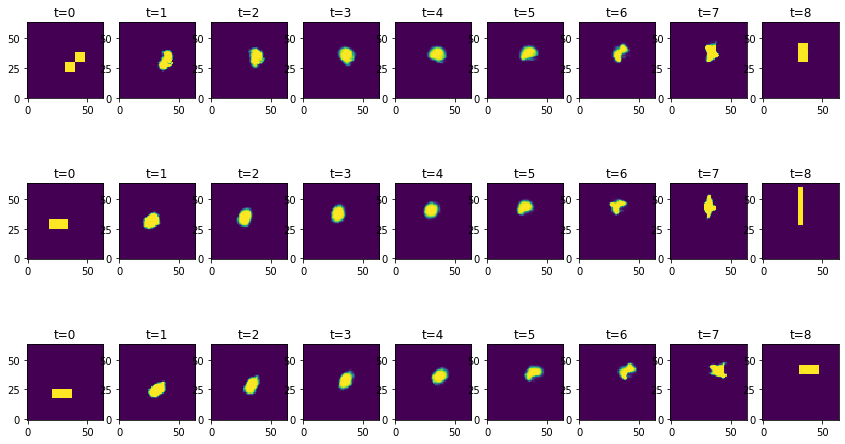

In [32]:
import pylab
batches = [0, 1, 2]
pylab.subplots(len(batches), 9, sharey='row', sharex='col', figsize=(12, 7))
pylab.tight_layout(w_pad=0)
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 9, t + 1 + i * 9)
        pylab.title('t=%d' % t * 2)
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')

Using the same procedure as with the Burgers example, we could use a `RefinedSequence` and train with the prediction refinement scheme. The results are already looking rather nice, so we'll leave it up to the reader ;-)